In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, max_error, mean_absolute_percentage_error
from scipy.stats import kurtosis, skew

In [3]:
train = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv',dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [4]:
pd.options.display.precision = 15
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [5]:
# Divide the input file in segments of the size specified

rows = 600_000 #TODO: Optimize this parameter

segments = int(np.floor(train.shape[0] / rows))

print(f"Number of segments:",segments)

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['avg', 'std', 'max', 'min', 'skw', 'kur', 'q05', 'q95'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in range(segments):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    y_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'avg'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'skw'] = skew(x)
    X_train.loc[segment, 'kur'] = kurtosis(x)
    X_train.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_train.loc[segment, 'q95'] = np.quantile(x, 0.95)

Number of segments: 1048


In [6]:
X_train.head()

,avg,std,max,min,skw,kur,q05,q95
0,4.854628333333333,6.440460548635521,197.0,-199.0,0.405332379089857,80.873688793864119,-2.0,12.0
1,4.795830000000000,6.115061837607750,145.0,-144.0,0.017928416437204,50.277880145110743,-2.0,12.0
2,4.590400000000000,9.732097127889070,410.0,-478.0,-0.613561811278541,313.967771375183020,-3.0,13.0
3,4.584881666666667,6.720502345013395,224.0,-169.0,-0.176054375542081,65.602062779256983,-3.0,12.0
4,4.502675000000000,6.669050370508158,145.0,-189.0,0.009721235872515,42.184898565065282,-3.0,12.0


In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [8]:
def plot(y_train, y_pred, model):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train.values.flatten(), y_pred)
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('actual', fontsize=12)
    plt.ylabel('predicted', fontsize=12)
    plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(y_train.values.flatten(), color='blue', label='y_train')
    plt.plot(y_pred, color='orange', label=model)
    plt.legend()
    plt.title(str(model) + " vs Actual")

In [9]:
def score(y_train, y_pred, best_param):
    y_train_flatten = y_train.values.flatten()
    max = max_error(y_train_flatten, y_pred)
    mae = mean_absolute_error(y_train_flatten, y_pred)
    mape = mean_absolute_percentage_error(y_train_flatten, y_pred)
    print("Best params: " + str(best_param))
    print(f'Max Error: {max:0.3f}')
    print(f'Mean Absolute Error: {mae:0.3f}')
    print(f'Mean Absolute Percentage Error: {mape:0.3f}')

In [10]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,avg,std,max,min,skw,kur,q05,q95
avg,1.000000000000000,0.006330247024193,0.015302570861634,-0.000829593073283,-0.008082305122352,0.002122266511130,0.168462082584392,0.154845778479211
std,0.006330247024193,1.000000000000000,0.964188878643568,-0.962345715708428,0.108418153756821,0.650764943166061,-0.722767280766057,0.725530129440546
max,0.015302570861634,0.964188878643568,1.000000000000000,-0.957605552104905,0.211101232371308,0.752978415144233,-0.656685148618111,0.663019081864619
min,-0.000829593073283,-0.962345715708428,-0.957605552104905,1.000000000000000,-0.017838171710215,-0.749858892638041,0.641199128594822,-0.643343494378145
skw,-0.008082305122352,0.108418153756821,0.211101232371308,-0.017838171710215,1.000000000000000,0.120902886436739,-0.115957184978727,0.111694464255352
kur,0.002122266511130,0.650764943166061,0.752978415144233,-0.749858892638041,0.120902886436739,1.000000000000000,-0.482080133264583,0.476338981726890
q05,0.168462082584392,-0.722767280766057,-0.656685148618111,0.641199128594822,-0.115957184978727,-0.482080133264583,1.000000000000000,-0.908284216579940
q95,0.154845778479211,0.725530129440546,0.663019081864619,-0.643343494378145,0.111694464255352,0.476338981726890,-0.908284216579940,1.000000000000000


# **Adaboost regressor**

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

parameters = [{'n_estimators':[5, 10, 20, 50, 100, 200], 'loss': ["linear", "square", "exponential"]}]

model = AdaBoostRegressor()

model_adaboostreg = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_adaboostreg.fit(X_train_scaled, y_train.values.flatten()) 
y_pred_adaboost = model_adaboostreg.predict(X_train_scaled)

In [12]:
score(y_train, y_pred_adaboost, model_adaboostreg.best_params_)

Best params: {'loss': 'exponential', 'n_estimators': 10}
Max Error: 8.299
Mean Absolute Error: 2.010
Mean Absolute Percentage Error: 2.842


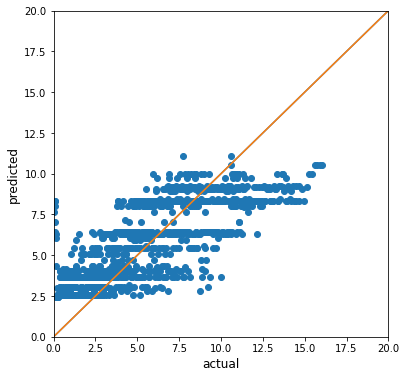

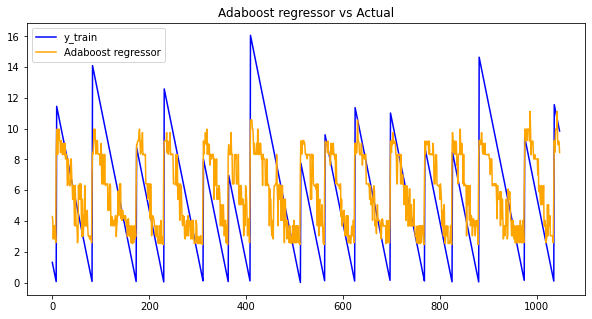

In [13]:
plot(y_train, y_pred_adaboost, "Adaboost regressor")

# **Bagging regressor**

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor

parameters = [{'n_estimators':[10, 20, 50, 100, 200, 500]}]

model = BaggingRegressor()

model_baggreg = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_baggreg.fit(X_train_scaled, y_train.values.flatten()) 
y_pred_baggreg = model_baggreg.predict(X_train_scaled)

In [15]:
score(y_train, y_pred_baggreg, model_baggreg.best_params_)

Best params: {'n_estimators': 100}
Max Error: 3.966
Mean Absolute Error: 0.750
Mean Absolute Percentage Error: 1.002


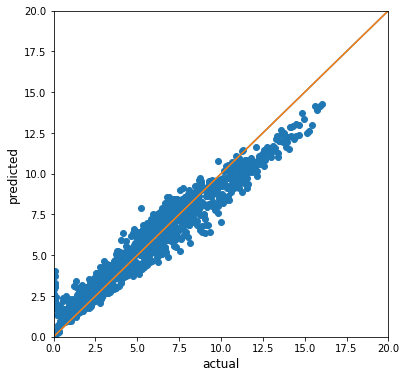

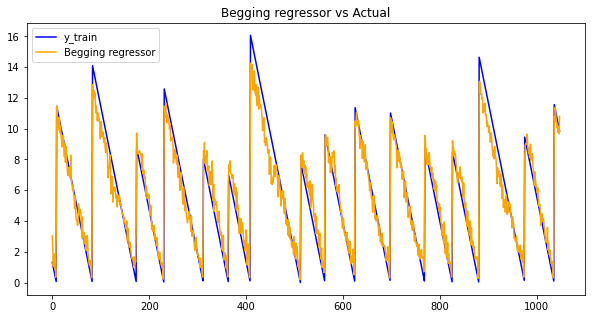

In [16]:
plot(y_train, y_pred_baggreg, "Begging regressor")

# **Random Forest Regressor**

In [17]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
parameters = {'n_estimators':[10, 20, 50, 100, 200, 500]}

model_randforest = GridSearchCV(model, parameters, cv=5)
model_randforest.fit(X_train_scaled, y_train.values.flatten()) #it takes 14minutes to fit
y_pred_randforest = model_randforest.predict(X_train_scaled)

In [18]:
score(y_train, y_pred_randforest, model_randforest.best_params_)

Best params: {'n_estimators': 200}
Max Error: 4.237
Mean Absolute Error: 0.752
Mean Absolute Percentage Error: 1.102


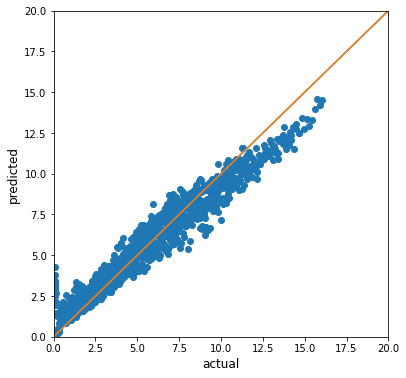

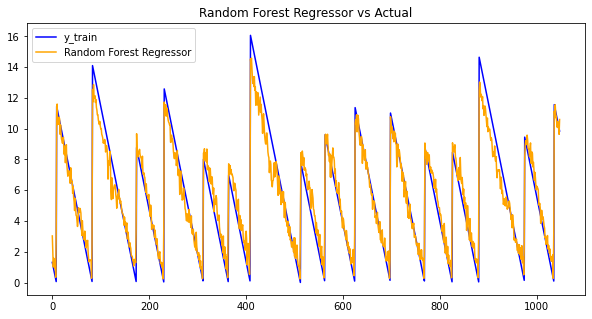

In [19]:
plot(y_train, y_pred_randforest, "Random Forest Regressor")

# **Support Vector Regressor (SVR)**

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

model = SVR(kernel='rbf', tol=0.01)
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]

model_SVR = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_SVR.fit(X_train_scaled, y_train.values.flatten()) # it takes 3 minutes to fit
y_pred_svr = model_SVR.predict(X_train_scaled)

In [21]:
score(y_train, y_pred_svr, model_SVR.best_params_)

Best params: {'C': 1.5, 'gamma': 0.05}
Max Error: 9.038
Mean Absolute Error: 1.885
Mean Absolute Percentage Error: 2.597


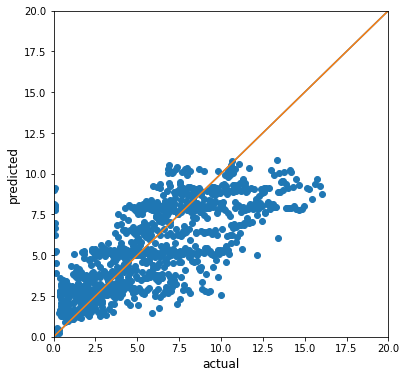

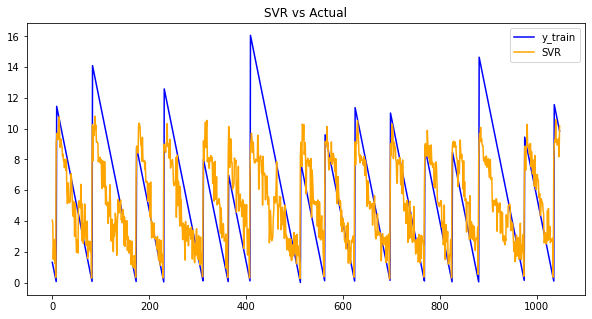

In [22]:
plot(y_train, y_pred_svr, "SVR")

# **Nu Support Vector Regressor (NuSVR)**

In [23]:
from sklearn.svm import NuSVR

model = NuSVR(kernel='rbf')
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]

model_regNuSVR = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_regNuSVR.fit(X_train_scaled, y_train.values.flatten()) # it takes 20 minutes to fit
y_pred_NuSVR = model_regNuSVR.predict(X_train_scaled)

In [24]:
score(y_train, y_pred_NuSVR, model_regNuSVR.best_params_)

Best params: {'C': 1.5, 'gamma': 0.05, 'nu': 0.95}
Max Error: 9.041
Mean Absolute Error: 1.884
Mean Absolute Percentage Error: 2.595


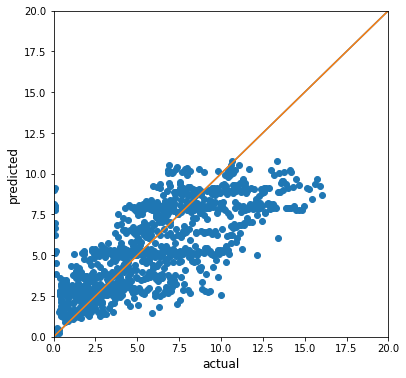

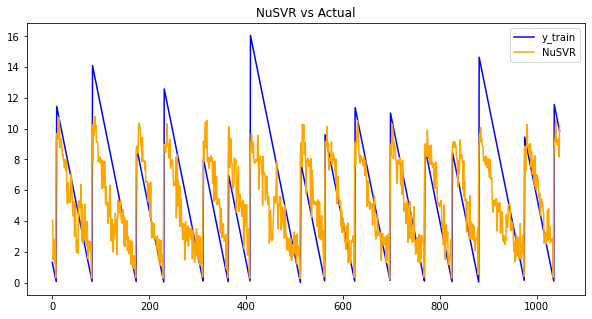

In [25]:
plot(y_train, y_pred_NuSVR, "NuSVR")

# **Kernel Ridge Regressor**

In [26]:
from sklearn.kernel_ridge import KernelRidge

model = KernelRidge(kernel='rbf')

parameters = [{'gamma': np.linspace(0.001, 0.1, 10),
               'alpha': [0.005, 0.01, 0.02, 0.05, 0.1]}]

model_KRR = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error') #neg_mean_absolute_error
model_KRR.fit(X_train_scaled, y_train.values.flatten()) # it takes 5 minutes to fit
y_pred_krr = model_KRR.predict(X_train_scaled)

In [27]:
score(y_train, y_pred_krr, model_KRR.best_params_)

Best params: {'alpha': 0.1, 'gamma': 0.012}
Max Error: 9.600
Mean Absolute Error: 1.931
Mean Absolute Percentage Error: 2.747


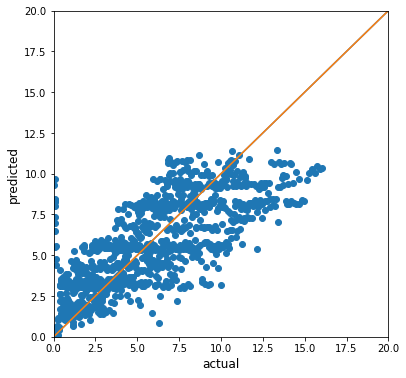

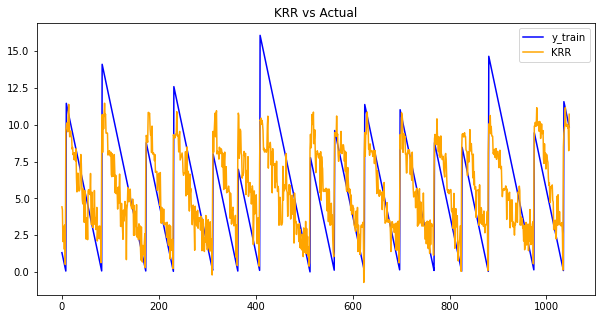

In [28]:
plot(y_train, y_pred_krr, "KRR")